In [45]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [46]:
def preprocessing(img_name):
    # read the img
    img=cv2.imread(img_name)
    # Red layer extraction
    # split img color channel to B,G,R
    b,g,r = cv2.split(img)
    # Adaptive histogram Equalization
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))    # adaptive
    cl1 = clahe.apply(r)
    # median filter
    median = cv2.medianBlur(cl1, 15)    # adaptive
    # down sampling
    down0=cv2.pyrDown(median)
    down1=cv2.pyrDown(down0)
    down2=cv2.pyrDown(down1)
    down3=cv2.pyrDown(down2)
    down4=cv2.pyrDown(down3)
    plt.imshow(down4, 'gray')
    return down4

In [47]:
import skfuzzy as fuzz
def processing(img):
    # save original img shape
    img_shape = img.shape
    # flat the matrix
    down4_ravel = img.reshape([1, -1])
    # B. Fuzzyc-meansBinarization
    ncenters = 25   # 25 classifier
    cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
        down4_ravel, ncenters, 2, error=0.005, maxiter=1000)
    # find the level/classifier of the brightest area.
    max_c = np.argmax(cntr, axis=0)
    # there are 25 classifiers totally. find every point's corresponding classify.
    cluster_membership = np.argmax(u, axis=0)
    # array of combination of pixels and corresponding clusters 
    a=np.array([down4_ravel,cluster_membership])
    # if one point is not the brightest area classifier, ouput 0
    x=np.where(a[1]==max_c, a[0], 0)
    # reshape it to original image shape
    down4_new = x.reshape(img_shape)
    plt.imshow(down4_new, 'gray')
    return down4_new

In [48]:
def postprocessing(img):
    # Morphological opening followed by dilation removes the noise parts.
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    # become to original size
    up0=cv2.pyrUp(opening)
    up1=cv2.pyrUp(up0)
    up2=cv2.pyrUp(up1)
    up3=cv2.pyrUp(up2)
    up4=cv2.pyrUp(up3)
    # thresholding makes img brighter
    res, threshold = cv2.threshold(up4,0,255,cv2.THRESH_BINARY)
    plt.imshow(threshold, 'gray')
    return threshold

In [49]:
def matching(img, true,ellipse=None):
    # Contour detection
    binary, contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    threshold_copy = img.copy()
    cnt = contours[0]
    # GRAY TO rgb
    color_channel = np.zeros(img.shape, np.uint8)
    threshold_copy = cv2.merge((threshold_copy, threshold_copy, threshold_copy))
    if ellipse == 'ellipse':
        # res = cv2.drawContours(up4_copy, contours, -1, (0,0,255), 2)
        mask1 = np.zeros(threshold_copy.shape, dtype="uint8")
        # Ellipse fitting
        ellipse = cv2.fitEllipse(cnt)
        res = cv2.ellipse(mask1, ellipse, (255, 0, 0), cv2.FILLED)
    else:
        # Contour approximately detection
        mask2 = np.zeros(threshold_copy.shape, dtype="uint8")
        epsilon = 0.005*cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt,epsilon,True)
        res = cv2.drawContours(mask2,[approx], -1, (255,0,0), cv2.FILLED)
    true = cv2.cvtColor(cv2.imread(true), cv2.COLOR_BGR2RGB)
    res_true = np.hstack((res, true))
    plt.imshow(res_true)
    return res

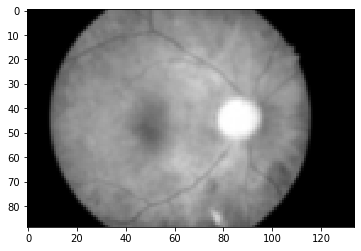

In [188]:
img = preprocessing('original_retinal_images/IDRiD_23.jpg')

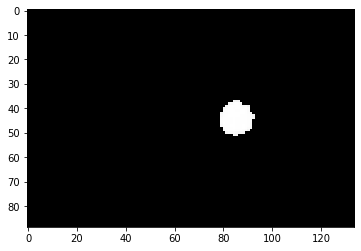

In [189]:
img = processing(img)

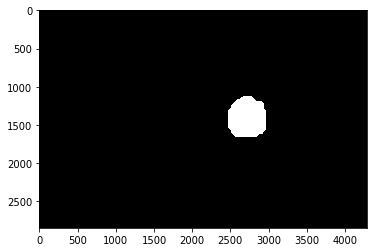

In [190]:
img = postprocessing(img)

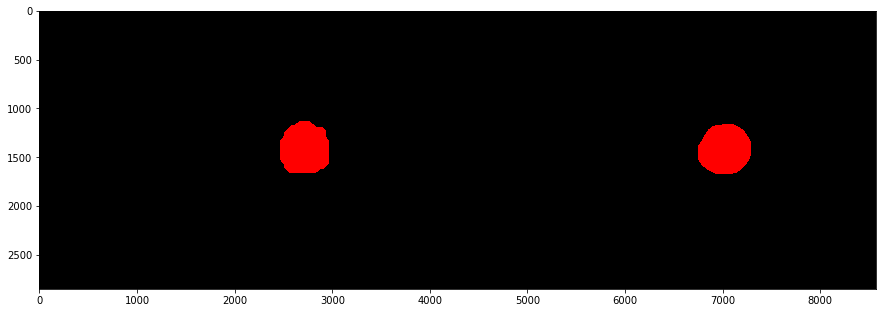

In [191]:
plt.figure(figsize=(15,8)) 
res = matching(img,'optic_disc_segmentation_masks/IDRiD_23_OD.tif')

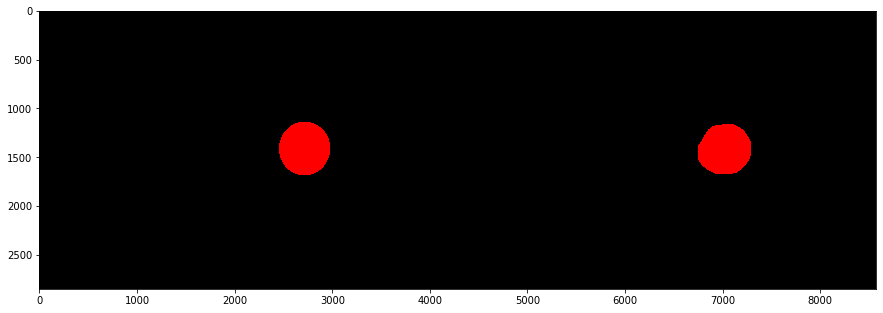

In [192]:
plt.figure(figsize=(15,8)) 
res_e = matching(img,'optic_disc_segmentation_masks/IDRiD_23_OD.tif', 'ellipse')

In [193]:
def J_loss(res, true):
    # ACCURACY
    true = cv2.imread(true)
    res_g = cv2.cvtColor(res,cv2.COLOR_RGB2GRAY)
    true_g = cv2.cvtColor(true,cv2.COLOR_BGR2GRAY)
    ret,res_g = cv2.threshold(res_g,0,255,cv2.THRESH_BINARY)
    ret,true_g = cv2.threshold(true_g,0,255,cv2.THRESH_BINARY)
    acc = cv2.bitwise_xor(res_g,true_g)
    acc = cv2.bitwise_not(acc)
    plt.imshow(acc,'gray')
    print("Accuracy: ", np.bincount(acc.flatten())[255]/acc.size)
    # f1 SCORE = 2*P*R/(P+R)
    # precision = TP/(TP+FP)
    # recall=TP/(TP+FN)=TP/P
    TP = np.sum(cv2.bitwise_and(res_g,true_g)==255)
    FP = np.sum((res_g - true_g)==255)
    FN = np.sum((true_g - res_g)==255)
    P = TP/(TP+FP)
    R = TP/(TP+FN)
    F1 = 2*P*R/(P+R)
    print("F1 Score: ", F1)

Accuracy:  0.9975500776926464
F1 Score:  0.9333012312487042


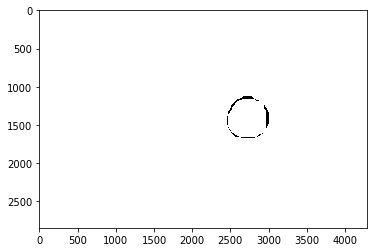

In [194]:
J_loss(res, 'optic_disc_segmentation_masks/IDRiD_23_OD.tif')

Accuracy:  0.9978787647524316
F1 Score:  0.9428404364470824


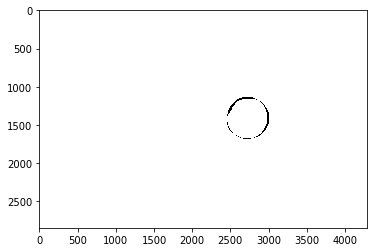

In [195]:
J_loss(res_e, 'optic_disc_segmentation_masks/IDRiD_23_OD.tif')

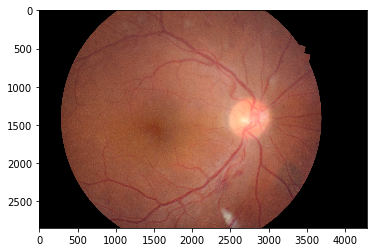

In [196]:
x = cv2.imread('original_retinal_images/IDRiD_23.jpg')
plt.imshow(cv2.cvtColor(x,cv2.COLOR_BGR2RGB))